<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/NLP/fastai%26BERT%E4%B8%AD%E6%96%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[如何在 fast.ai 用 BERT 做中文文本分类？](https://zhuanlan.zhihu.com/p/75606225)

In [0]:
!wget https://github.com/wshuyi/public_datasets/raw/master/dianping.csv

In [0]:
from fastai.text import *

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("dianping.csv")
train, test = train_test_split(df, test_size=.2, random_state=2)
train, valid = train_test_split(train, test_size=.2, random_state=2)
print(len(train))
print(len(valid))
print(len(test))

1280
320
400


In [3]:
train.head()

,comment,sentiment
330,跟老公去大悦城玩儿的时候吃的，味道真的还不错哦！这家店是一对年轻的小两口自主创业开的店，环境...,1
1326,味道是好，但是真的很生气，排了两个小时的队伍就为了吃干酪鱼，进来被告知没有了，我觉得起码没有...,0
666,还好吧，调调不错，排队人多。。,1
1753,星期一人依旧是那么多，五点刚过就到了，基本上坐满了。菜品种类不少，这次赶上了青口贝挺好的。烤...,1
1885,4点半进去没等座。大拉皮好实惠。麻酱别都放否则太甜。薰骨肉香味浓。家常茄子精工细做，很好。还...,1


In [0]:
!pip install transformers

In [0]:
from transformers import BertTokenizer, BertForSequenceClassification
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

In [6]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [0]:
#我们把全部的词汇列表存储起来，下面要用到。
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

In [0]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)
path = Path(".")


In [12]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [13]:
databunch.show_batch()

text,target
[CLS] 先 团 的 券 ， 进 去 后 就 不 想 吃 了 ， 把 券 退 了 ， 因 为 同 伴 拿 了 一 杯 水 回 来 ， 服 务 员 告 知 必 须 交 钱 了 ， 那 就 在 这 吃 吧 。 结 果 交 的 现 金 。 客 观 的 说 ， 东 西 种 类 是 不 少 ，,0
[CLS] 两 个 人 点 了 四 个 菜 一 壶 梨 汤 ， 口 味 还 可 以 ， 没 有 特 别 出 众 ， 菜 的 价 位 相 对 高 了 点 ， 排 队 的 人 倒 是 很 多 ， 上 菜 挺 快 的 ， 就 是 点 的 米 饭 催 了 好 几 遍 才 端 上 来 ， 菜 都,0
[CLS] 实 在 不 理 解 为 什 么 点 评 这 么 火 ， 外 边 还 有 好 多 人 排 队 。 这 个 菜 的 口 味 放 北 京 也 许 是 正 常 的 ， 但 是 在 天 津 这 种 风 味 水 平 根 本 不 值 得 尝 试 ， 更 别 提 排 队 了 。 随 便 找,0
[CLS] 发 现 这 家 店 也 是 搜 寻 滨 江 道 隐 秘 的 小 吃 发 现 的 ， 看 [UNK] 上 评 价 比 较 看 ， 然 后 看 了 看 菜 单 比 较 有 特 色 ， 觉 得 应 该 是 挺 文 艺 的 一 个 创 意 菜 小 店 ， 然 后 有 天 下 班 就 和 同,0
[CLS] 今 天 从 门 口 过 ， 觉 得 能 进 娜 娜 家 ， 果 断 冲 过 来 ， 哈 哈 ， 抢 到 大 的 沙 发 桌 喽 [UNK] [UNK] 彩 虹 [UNK] 沙 拉 种 类 多 多 ， 牛 油 果 番 茄 芝 士 鸡 蛋 [UNK] 补 充 营 养 ， 味 道 也 不 错 😂 看 点 评 选,1


In [0]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [0]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


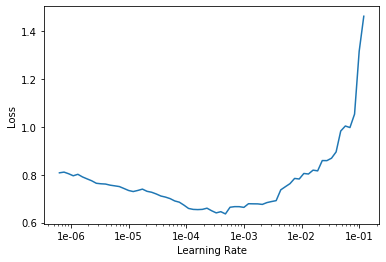

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.572303,0.407918,0.821875,00:10
1,0.383242,0.310867,0.878125,00:10


In [0]:
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['comment'])[1]))
  return preds

In [0]:
preds = dumb_series_prediction(len(test))

In [25]:
preds[:10]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       203
           1       0.86      0.88      0.87       197

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [28]:
print(confusion_matrix(test.sentiment, preds))

[[175  28]
 [ 23 174]]
